In [1]:
import numpy as np
import glob
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Model
from skimage.transform import resize
from PIL import Image, ImageOps
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.layers import Input, Conv2D, Flatten, MaxPooling2D, Dense, BatchNormalization, DepthwiseConv2D, LeakyReLU, Add, GlobalMaxPooling2D

Using TensorFlow backend.


In [2]:
# directory path 
path = '../input/cropped images/'

# accessing images from data 
images_list = glob.glob(os.path.join(path, '*/*.jpg'))

# length of data 
print(len(images_list))

4580


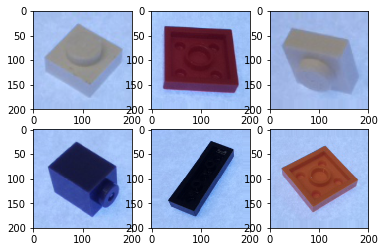

In [3]:
for i, img_path in enumerate(random.sample(images_list, 6)):
    #load image 
    img = load_img(img_path)
    
    #converting image into array 
    img = img_to_array(img, dtype=np.uint8)

    size = img.shape[:2]
    r = 200. / max(size)
    size = tuple([int(x*r) for x in size])
    
    #resize 
    img = resize(img, output_shape=size, mode='edge', preserve_range=True).astype(np.uint8)
    
    #height and width 
    w = 200 - new_size[1]
    h = 200 - new_size[0]
    pad = ((h//2, h-(h//2)), (w//2, w-(w//2)), (0, 0))
    
    img = np.pad(img, pad, 'edge')
    
    # plotting some images 
    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze())

In [4]:
def resizing(img):
    size = img.shape[:2]
    r = 200. / max(size)
    size = tuple([int(x*r) for x in size])
    img = resize(img, output_shape=size, mode='edge', preserve_range=True)
    w = 200 - new_size[1]
    h = 200 - new_size[0]
    padding = ((h//2, h-(h//2)), (w//2, w-(w//2)), (0, 0))
    img = np.pad(img, padding, 'edge')
    return img

def preprocess_train(img):
    img = resizing(img)
    return img

def preprocess_val(img):
    img = resizing(img)
    return img

# Data Augmentation 
train_ds = ImageDataGenerator(preprocessing_function=preprocess_train, rescale=1./255, zoom_range=0.05, 
                              width_shift_range=0.05, height_shift_range=0.05, horizontal_flip=True,vertical_flip=True, 
                              rotation_range=90, validation_split=0.1)

test_ds = ImageDataGenerator(preprocessing_function=preprocess_val, rescale=1./255, validation_split=0.1)

#Using flow_from_directory to access the image from directory 
train_ds = train_ds.flow_from_directory(path, color_mode='grayscale', target_size=(200, 200), batch_size=32, 
                                        class_mode='categorical', subset='training', seed=0)

val_ds = test_datagen.flow_from_directory(path, color_mode='grayscale',target_size=(200, 200), batch_size=32,
                                          class_mode='categorical', subset='validation', seed=0)

#Label Encoding 
lbl = (train_ds.class_indices)
lbl = dict((v,k) for k,v in lbl.items())

print(lbl)

Found 4133 images belonging to 20 classes.
Found 447 images belonging to 20 classes.
{0: 'Brick_1x1', 1: 'Brick_1x2', 2: 'Brick_1x3', 3: 'Brick_1x4', 4: 'Brick_2x2', 5: 'Brick_2x2_L', 6: 'Brick_2x2_Slope', 7: 'Brick_2x3', 8: 'Brick_2x4', 9: 'Plate_1x1', 10: 'Plate_1x1_Round', 11: 'Plate_1x1_Slope', 12: 'Plate_1x2', 13: 'Plate_1x2_Grill', 14: 'Plate_1x3', 15: 'Plate_1x4', 16: 'Plate_2x2', 17: 'Plate_2x2_L', 18: 'Plate_2x3', 19: 'Plate_2x4'}


In [5]:
# input layer 
inp = Input(shape=(200, 200, 1))

#Convolutional layers 
m = Conv2D(filters=64, kernel_size=3, padding='same')(inp)
m = LeakyReLU()(m)
m = MaxPooling2D()(m)
m = Conv2D(filters=64, kernel_size=3, padding='same')(m)
m = LeakyReLU()(m)
m = MaxPooling2D()(m)
m = Conv2D(filters=64, kernel_size=3, padding='same')(m)
m = LeakyReLU()(m)
m = MaxPooling2D()(m)

shortcut = m

m = DepthwiseConv2D(kernel_size=3, padding='same')(m)
m = LeakyReLU()(m)
m = Conv2D(filters=64, kernel_size=1, padding='same')(m)
m = LeakyReLU()(m)
m = DepthwiseConv2D(kernel_size=3, padding='same')(m)
m = LeakyReLU()(m)
m = Conv2D(filters=64, kernel_size=1, padding='same')(m)
m = LeakyReLU()(m)

m = Add()([shortcut, m])

m = Conv2D(filters=64, kernel_size=3, padding='same')(m)
m = LeakyReLU()(m)
m = MaxPooling2D()(m)
m = Conv2D(filters=64, kernel_size=3, padding='same')(m)
m = LeakyReLU()(m)
m = MaxPooling2D()(m)
m = DepthwiseConv2D(kernel_size=3, padding='same')(m)
m = LeakyReLU()(m)
m = Conv2D(filters=128, kernel_size=1, padding='same')(m)
m = LeakyReLU()(m)

# flattening input 
m = Flatten()(m)

#classification lalyer
m = Dense(128, activation='relu')(m)
m = Dense(64, activation='relu')(m)
outputs = Dense(20, activation='softmax')(m)

# final model
model = Model(inputs=inputs, outputs=outputs)

# compile the model 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

# model looks like 
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 200, 200, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 200, 200, 64) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 100, 100, 64) 0           leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
conv2d_2 (

In [6]:
# training 
model.fit_generator(train_ds, epochs=50, batch_size=8, validation_data=val_ds)

Epoch 1/50
130/130 [==============================] - 57s 442ms/step - loss: 2.9922 - acc: 0.0630 - val_loss: 2.9857 - val_acc: 0.0716
Epoch 2/50
130/130 [==============================] - 48s 369ms/step - loss: 2.9874 - acc: 0.0704 - val_loss: 2.9845 - val_acc: 0.0694
Epoch 3/50
130/130 [==============================] - 47s 363ms/step - loss: 2.9827 - acc: 0.0746 - val_loss: 2.9700 - val_acc: 0.0761
Epoch 4/50
130/130 [==============================] - 47s 360ms/step - loss: 2.8969 - acc: 0.1007 - val_loss: 2.7385 - val_acc: 0.1298
Epoch 5/50
130/130 [==============================] - 47s 361ms/step - loss: 2.5686 - acc: 0.1806 - val_loss: 2.4796 - val_acc: 0.2550
Epoch 6/50
130/130 [==============================] - 47s 361ms/step - loss: 2.2548 - acc: 0.2721 - val_loss: 2.2784 - val_acc: 0.3132
Epoch 7/50
130/130 [==============================] - 47s 362ms/step - loss: 2.0528 - acc: 0.3208 - val_loss: 2.1507 - val_acc: 0.3669
Epoch 8/50
130/130 [==============================] - 4